In [1]:
# To predict fine Particulate matter (PM2.5) based on meteorological, time and geographical features.
# Preprocessing including transformation, visualization, fitting and cross validation of model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from sklearn.model_selection import LeaveOneOut
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [4]:
from numpy import mean
from numpy import sqrt
from numpy import absolute

In [5]:
data=pd.read_excel(r'C:/Users/LENOVO/Documents/Diwali_Impact_coding/Modelling/Model_Data.xlsx',usecols=['Hour','PM','RH','WS','Type','Popu','FRP','Region'],sheet_name='Data_cook2')

In [6]:
data.dropna(subset=['PM','RH','WS'],inplace=True)

In [7]:
data.isna().sum() # No nan/missing values present now.

PM        0
WS        0
FRP       0
RH        0
Region    0
Popu      0
Type      0
Hour      0
dtype: int64

### 1.PreProcessing of Data

#### 1.1. Correlation

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_num = data.select_dtypes(include=numerics)

In [9]:
data_num.corr()

,PM,WS,FRP,RH,Hour
PM,1.000000,-0.154052,0.234338,-0.002773,-0.022165
WS,-0.154052,1.000000,-0.080286,-0.035513,0.047584
FRP,0.234338,-0.080286,1.000000,-0.147160,0.002536
RH,-0.002773,-0.035513,-0.147160,1.000000,-0.231441
Hour,-0.022165,0.047584,0.002536,-0.231441,1.000000


#### 1.2. Multicollinearity

In [10]:
vif_data = pd.DataFrame()
vif_data["feature"] = data_num.columns
vif_data["VIF"] = [variance_inflation_factor(data_num.values, i) for i in range(len(data_num.columns))]

print(vif_data)
# Since all variables have vif value between 1-4, there is no multicollinearity seen.

  feature       VIF
0      PM  1.800286
1      WS  1.957538
2     FRP  1.444510
3      RH  3.538119
4    Hour  2.828710


#### 1.3. Scatter Plot 

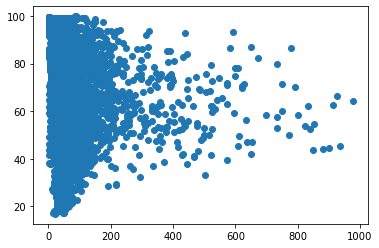

In [11]:
plt.scatter(data.PM,data.RH) # there is pattern of  distribution is visible.

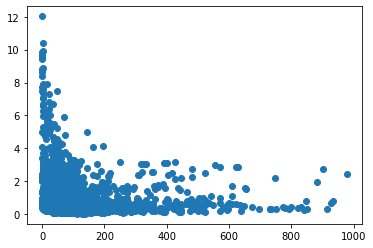

In [12]:
plt.scatter(data.PM,data.WS) # there is pattern of  distribution is visible.

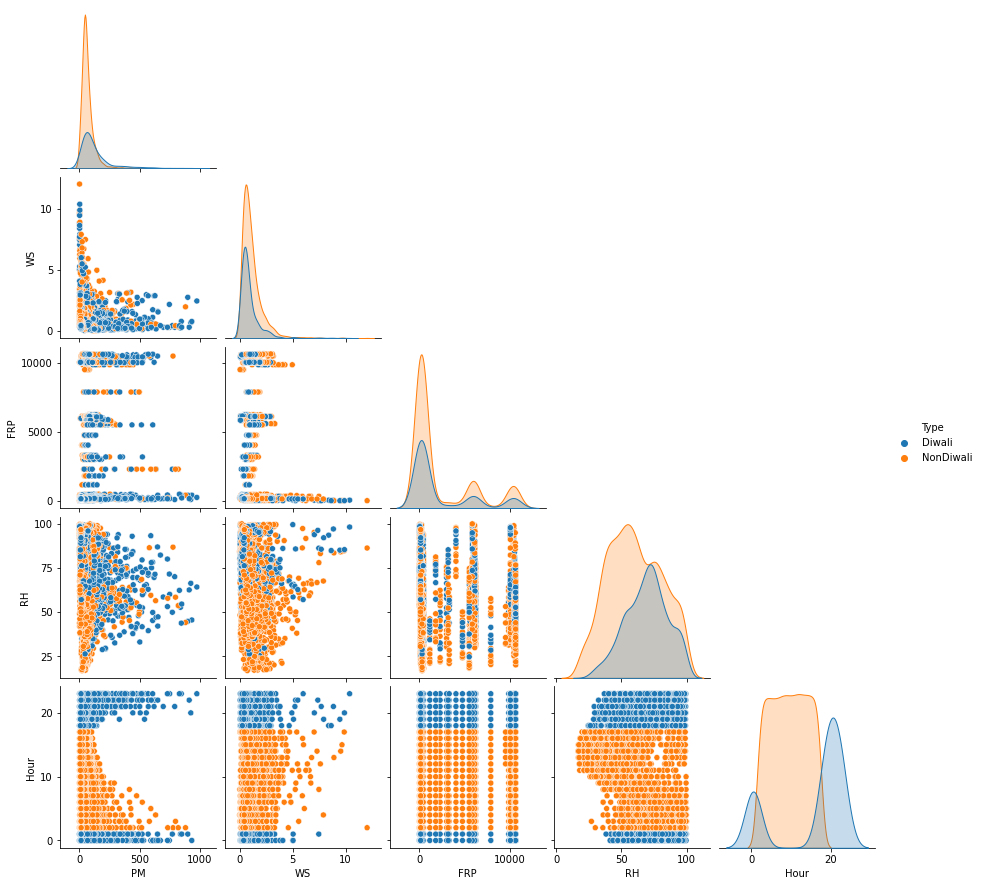

In [13]:
sns.pairplot(data=data, diag_kind='kde',hue='Type',corner=True)
sns.set_context("paper", rc={"axes.labelsize":18})
sns.set_context("notebook", font_scale=1.5)

In [14]:
# Since there is unique and patter in distribution of variables, we need to do variable transformation.

### 2.Data Transformation

#### 2.1. Log Transformation <of selected features based on scatterplot/distribution>

In [15]:
data_transformed=pd.read_excel(r'C:/Users/LENOVO/Documents/Diwali_Impact_coding/Modelling/Model_Data.xlsx',usecols=['Hour','PMlog','RH','WSlog','Type','Popu','FRPlog','Region'],sheet_name='Data_cook2')

In [16]:
data_transformed.dropna(subset=['PMlog','RH','WSlog'],inplace=True)

data_transformed.isna().sum() # No nan/missing values present now.

PMlog     0
WSlog     0
FRPlog    0
RH        0
Region    0
Popu      0
Type      0
Hour      0
dtype: int64

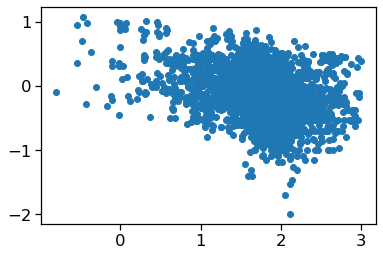

In [17]:
plt.scatter(data_transformed.PMlog,data_transformed.WSlog) # we can see there is good transformation happened

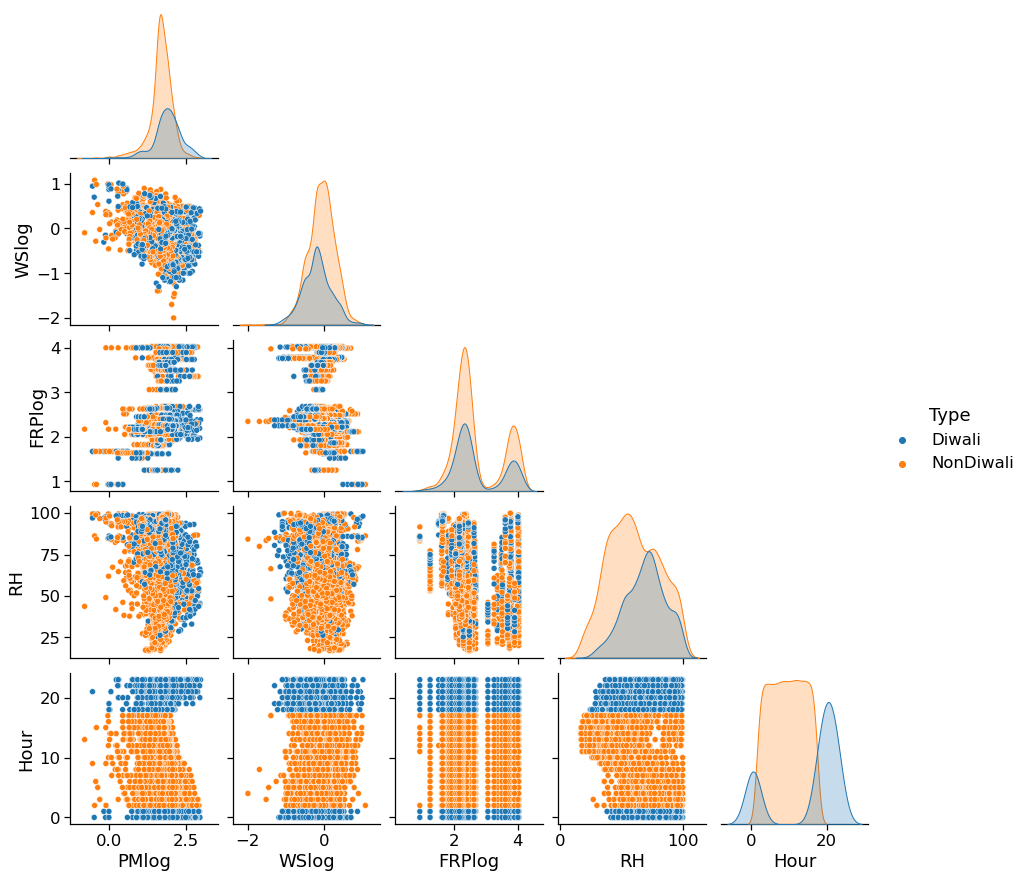

In [18]:
sns.pairplot(data=data_transformed, diag_kind='kde',hue='Type',corner=True)
sns.set_context("paper", rc={"axes.labelsize":18})
sns.set_context("notebook", font_scale=1.5)

#### 2.2. Cyclic Transformation < of time period 'Hour'>

In [19]:
def code_cyclic_features(data,columns,drop_cols=True):
    for col in columns:
        max_val=max(data[col])

        data[col+'_sin']=np.sin(2*np.pi*data[col]/max_val)
        data[col+'_cos']=np.cos(2*np.pi*data[col]/max_val)

        if drop_cols:
            del data[col]
            return data  

In [20]:
code_cyclic_features(data_transformed, ['Hour'])

,PMlog,WSlog,FRPlog,RH,Region,Popu,Type,Hour_sin,Hour_cos
0,2.330596,-0.101458,3.741850,65.394,North,Urban,Diwali,0.000000e+00,1.000000
1,2.109432,-0.119186,3.741850,68.068,North,Urban,Diwali,2.697968e-01,0.962917
2,2.023589,-0.055517,3.741850,73.444,North,Urban,NonDiwali,5.195840e-01,0.854419
3,1.926848,-0.074001,3.741850,72.410,North,Urban,NonDiwali,7.308360e-01,0.682553
4,1.870589,-0.096910,3.741850,73.332,North,Urban,NonDiwali,8.878852e-01,0.460065
...,...,...,...,...,...,...,...,...,...
4757,0.889862,-0.392545,2.169777,85.150,NorthEast,SemiUrban,Diwali,-8.878852e-01,0.460065
4758,0.946207,-0.346787,2.169777,88.940,NorthEast,SemiUrban,Diwali,-7.308360e-01,0.682553
4759,1.056905,-0.376751,2.169777,88.950,NorthEast,SemiUrban,Diwali,-5.195840e-01,0.854419
4760,1.082606,-0.468521,2.169777,90.605,NorthEast,SemiUrban,Diwali,-2.697968e-01,0.962917


### 3. Modelling

#### 3.1. Creating Dummy variables to convert categorical columns

In [21]:
data_transformed=pd.get_dummies(data_transformed, columns = ['Region','Popu','Type'])
print(data_transformed.shape)

(3737, 17)


#### 3.2. Fitting of model

In [22]:
LR=LinearRegression()

In [23]:
X=data_transformed.loc[:,data_transformed.columns!='PMlog'] # Indepenedent/Predictor Variables
y=data_transformed.loc[:,'PMlog'] # Dependent Variable

In [24]:
model=LR.fit(X,y)

#### 3.3. Model results

In [25]:
print(model.intercept_, model.coef_, model.score(X, y))

1.60262642182835 [-0.1896188   0.1224209  -0.00361834  0.15435474  0.09121654  0.1374311
  0.07261672  0.1317231  -0.60799206  0.08559288  0.18062827  0.10145074
 -0.09784834 -0.0036024   0.11088259 -0.11088259] 0.5777145044302863


In [26]:
# After the transformation of PM, WS and FRP features with log and cyclic transformation of Hour into sin and cosin
# model has incresed its explainability (r2) from 0.27 to o.577 now.

In [27]:
y_new=model.predict(X) # y_predicted

In [28]:
mse = mean_squared_error(y, y_new)
rmse = math.sqrt(mse)
print(rmse)

0.284939817782797


### 4. Cross Validation

In [29]:
cv=LeaveOneOut()

In [30]:
scores= cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
rmse_cv=mean(absolute(scores))
print(rmse_cv)

0.21293397120928462
